In [23]:
# Cell 1: Imports

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import AdamW


In [24]:
# Cell 2: Set directories and parameters

# Base directory
base_path = "C:/Users/breck/Documents/Homework/STAT 883/Final Project/Step 2 - Segmentation/DBT Dataset"

# Raw images
raw_image_dir = Path(os.path.join(base_path, "Training dataset", "Image"))
raw_mask_dir = Path(os.path.join(base_path, "Training dataset", "Ground truth"))

# Processed images
processed_image_dir = Path(os.path.join(base_path, "Processed dataset", "Image"))
processed_mask_dir = Path(os.path.join(base_path, "Processed dataset", "Ground truth"))

os.makedirs(processed_image_dir, exist_ok=True)
os.makedirs(processed_mask_dir, exist_ok=True)

# Train and validation images
val_test_image_dir = Path(os.path.join(base_path, "Testing dataset", "Image"))
val_test_images = sorted(val_test_image_dir.glob("*.png"))

val_test_mask_dir = Path(os.path.join(base_path, "Testing dataset", "Ground truth"))
val_test_masks = sorted(val_test_mask_dir.glob("*.png"))

# Parameters
img_height, img_width = 128, 128
# img_height, img_width = 256, 256
# img_height, img_width = 1024, 1024
batch_size = 4
epochs = 300
initial_lr = 1e-4
warmup_steps = 500
decay_rate = 0.1
decay_steps = 500
patience = 5


In [25]:
# Cell 3: Preprocess Raw Images and Masks

for image_file in Path(raw_image_dir).glob("*.png"):
    # Load and resize image
    image = Image.open(image_file).convert('L').resize((img_width, img_height), Image.BILINEAR)
    
    # Load and resize its corresponding mask
    mask_file = raw_mask_dir / image_file.name
    mask = Image.open(mask_file).convert('L').resize((img_width, img_height), Image.NEAREST)
    mask = (np.array(mask) > 127).astype(np.uint8) * 255
    mask = Image.fromarray(mask)
    
    # Save processed images and masks
    image.save(processed_image_dir / image_file.name)
    mask.save(processed_mask_dir / mask_file.name)

# Get objects for the images
train_images = sorted(Path(processed_image_dir).glob("*.png"))
train_mask_files = sorted(Path(processed_mask_dir).glob("*.png"))


In [26]:
# Cell 4: Load Data

def load_images_and_masks(image_files, mask_files, img_height, img_width):
    """Load and preprocess images and masks."""
    n = len(image_files)
    X = np.zeros((n, img_height, img_width, 1), dtype=np.float32)
    y = np.zeros((n, img_height, img_width, 1), dtype=np.float32)

    for i, (image_file, mask_file) in enumerate(zip(image_files, mask_files)):
        # Load and resize images and masks
        image = img_to_array(load_img(image_file, color_mode='grayscale', 
                                      target_size=(img_height, img_width))) / 255.0
        mask = img_to_array(load_img(mask_file, color_mode='grayscale', 
                                     target_size=(img_height, img_width))) / 255.0
        mask = (mask > 0.5).astype(np.float32)

        X[i] = image
        y[i] = mask
    
    return X, y

# Load train and test images/masks
X_train, y_train = load_images_and_masks(train_images, train_mask_files, img_height, img_width)
X_test, y_test = load_images_and_masks(val_test_images, val_test_masks, img_height, img_width)

# Split into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4)

print(f"Training set size:", X_train.shape[0])
print(f"Validation set size:", X_val.shape[0])
print(f"Test set size:", X_test.shape[0])


Training set size: 50
Validation set size: 15
Test set size: 10


In [27]:
# Cell 5: Build U-Net Model

input_size = (img_height, img_width, 1)
inputs = Input(input_size)

# Encoder
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

# Bottleneck
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(0.2)(conv4)  # Trying a tiny amount of dropout

# Decoder
upconv5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4)
concat5 = concatenate([upconv5, conv3])
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat5)
conv5 = BatchNormalization()(conv5)
conv5 = Dropout(0.1)(conv5)  # Trying a tiny amount of dropout

upconv6 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv5)
concat6 = concatenate([upconv6, conv2])
conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(concat6)
conv6 = BatchNormalization()(conv6)

upconv7 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(conv6)
concat7 = concatenate([upconv7, conv1])
conv7 = Conv2D(8, (3, 3), activation='relu', padding='same')(concat7)
conv7 = BatchNormalization()(conv7)

# Output
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │         80 │ input_layer_2[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         32 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64, 8) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │      1,168 │ max_pooling2d_6[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │      4,640 │ max_pooling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 32, 32,    │      8,224 │ dropout_4[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │     18,464 │ concatenate_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_20[0][0] 

 Total params: 60,153 (234.97 KB)

 Trainable params: 59,801 (233.60 KB)

 Non-trainable params: 352 (1.38 KB)

In [28]:
# Cell 6: Model loss and 

# Dice loss
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.0*intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


# Augmentation
transform = A.Compose(
    [
        A.Rotate(limit=20, p=0.5), 
        A.HorizontalFlip(p=0.5), 
        A.VerticalFlip(p=0.5), 
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5), 
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5), 
        A.ElasticTransform(p=0.5), 
        A.RandomCrop(height=img_height, width=img_width, p=0.5), 
        A.GaussNoise(p=0.5)
    ],
    additional_targets={'mask': 'mask'}
)

def augment(images, masks, batch_size):
    while True:
        indices = np.random.randint(0, len(images), batch_size)
        batch_images = images[indices]
        batch_masks = masks[indices]
        augmented_images = np.zeros_like(batch_images)
        augmented_masks = np.zeros_like(batch_masks)

        for i in range(batch_size):
            augmented = transform(image=batch_images[i], mask=batch_masks[i])
            augmented_images[i] = augmented['image']
            augmented_masks[i] = augmented['mask']

        yield augmented_images, augmented_masks


# Learning rate scheduler
class WarmupDecaySchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps, decay_rate, decay_steps):
        super(WarmupDecaySchedule, self).__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # For tf to not be mad
        warmup_lr = self.initial_lr * (step / self.warmup_steps)
        decay_lr = self.initial_lr * tf.math.exp(
            -self.decay_rate * (step-self.warmup_steps) / self.decay_steps)
        return tf.where(step < self.warmup_steps, warmup_lr, decay_lr)
    
    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "warmup_steps": self.warmup_steps,
            "decay_rate": self.decay_rate,
            "decay_steps": self.decay_steps
        }

# Learning rate logger
class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self, lr_schedule):
        super().__init__()
        self.lr_schedule = lr_schedule
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.lr_schedule(epoch)
        self.lrs.append(tf.keras.backend.get_value(lr))


Epoch 1/300
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - dice_coefficient: 0.0792 - loss: 0.9208 - val_dice_coefficient: 0.1447 - val_loss: 0.8553
Epoch 2/300
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - dice_coefficient: 0.1196 - loss: 0.8804 - val_dice_coefficient: 0.2160 - val_loss: 0.7840
Epoch 3/300
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - dice_coefficient: 0.1441 - loss: 0.8559 - val_dice_coefficient: 0.2449 - val_loss: 0.7551
Epoch 4/300
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - dice_coefficient: 0.1823 - loss: 0.8177 - val_dice_coefficient: 0.2236 - val_loss: 0.7764
Epoch 5/300
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - dice_coefficient: 0.1880 - loss: 0.8120 - val_dice_coefficient: 0.3031 - val_loss: 0.6969
Epoch 6/300
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - dice_coefficient: 0.2128 - loss: 0.7872 - val_dice_coefficient: 0.3278 - val_loss: 0.6722
Epoch 7/300
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - dice_coefficient: 0.2202 - loss: 0.7798 - val_dice_coefficient: 0.34

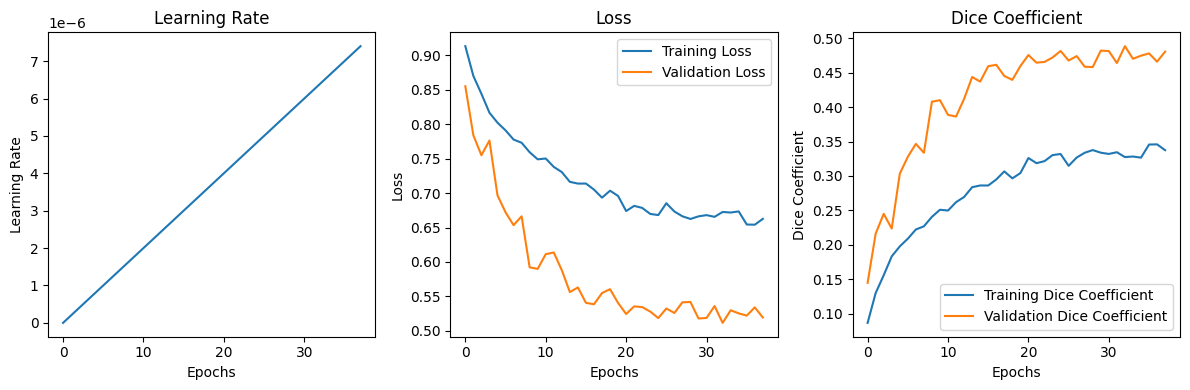

In [29]:
# Cell 7: Run the model

# Compile the model
checkpoint = ModelCheckpoint('unet_model.keras', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
lr_schedule = WarmupDecaySchedule(initial_lr, warmup_steps, decay_rate, decay_steps)
lr_logger = LearningRateLogger(lr_schedule)

model.compile(
    optimizer=AdamW(learning_rate=lr_schedule, weight_decay=1e-5),
    loss=dice_loss,
    metrics=[dice_coefficient]
)

# Train the model
history = model.fit(
    augment(X_train, y_train, batch_size), 
    steps_per_epoch= (25 * len(X_train)) // batch_size, 
    validation_data=(X_val, y_val), 
    epochs=epochs, 
    callbacks=[checkpoint, early_stop, lr_logger]
)

# Plots
plt.figure(figsize=(12, 4))

# Learning Rate
plt.subplot(1, 3, 1)
plt.plot(lr_logger.lrs, label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate')

# Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

# Dice Coefficient
plt.subplot(1, 3, 3)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test Dice Coefficient: 0.4420
Test IoU Score: 0.2837


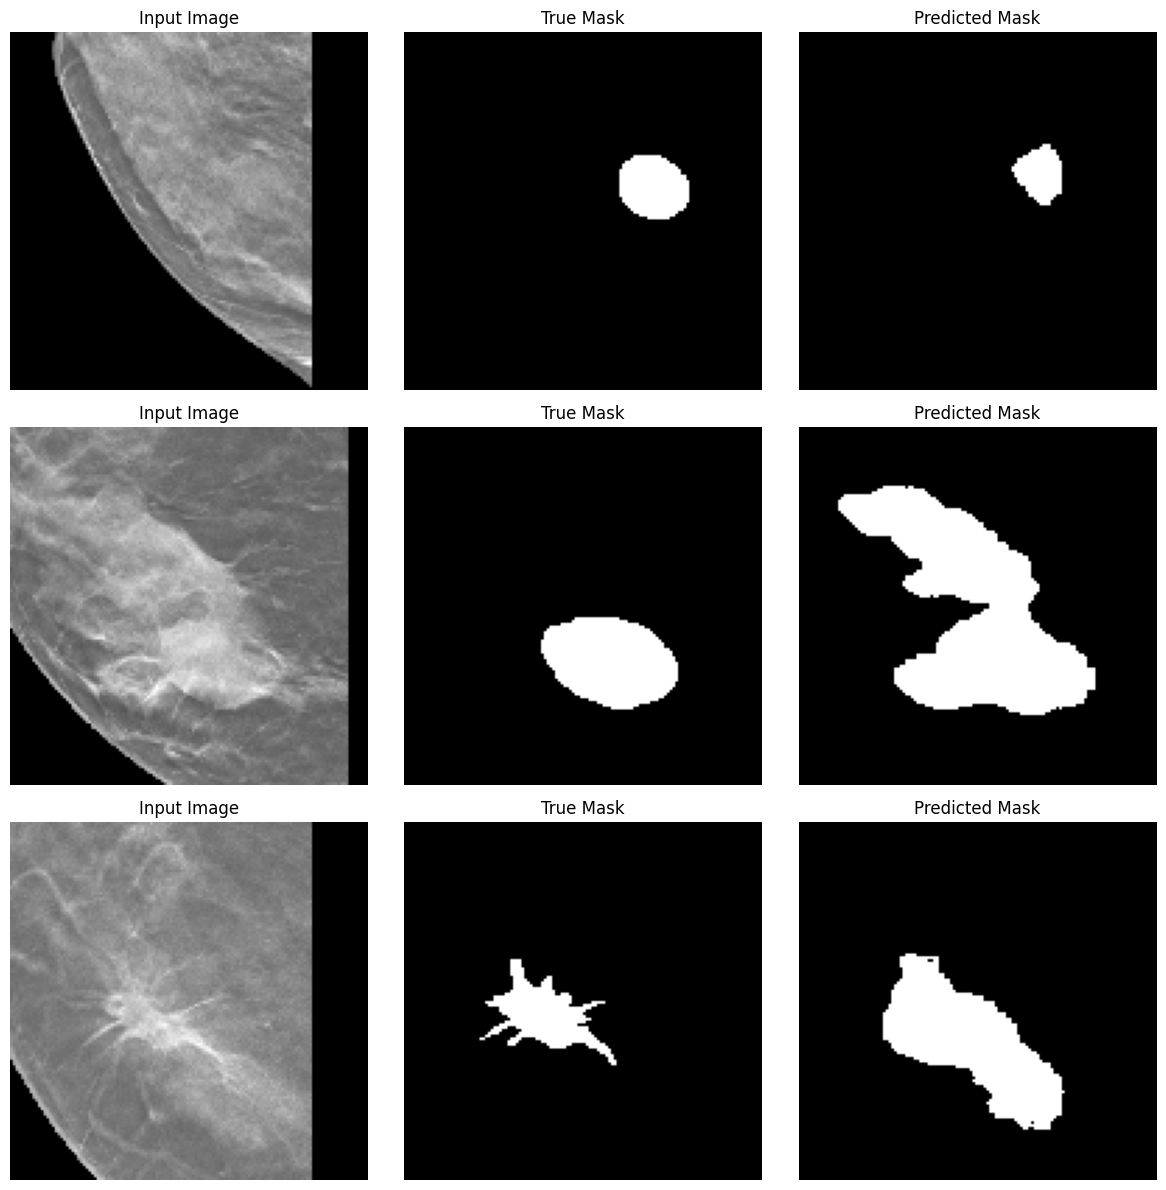

In [33]:
# Cell 8: Model Evaluation

# Load model if it doesn't exist
try:
    if model:
        pass
except NameError:
    model = tf.keras.models.load_model(
        'best_model.keras',
        custom_objects={'dice_loss': dice_loss, 'dice_coefficient': dice_coefficient}
    )

# Predict on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(np.float32)

y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Dice Coefficient and IoU
dice_score = (2.0 * np.sum(y_test_flat*y_pred_flat) + 1e-6) / (
    np.sum(y_test_flat) + np.sum(y_pred_flat) + 1e-6)
iou_score = jaccard_score(y_test_flat, y_pred_flat, average='binary')

print(f"Test Dice Coefficient: {dice_score:.4f}")
print(f"Test IoU Score: {iou_score:.4f}")

# Visualization
def plot_sample_images(X, y_true, y_pred):
    plt.figure(figsize=(12, 3 * 4))
    for i, idx in enumerate(np.random.randint(0, X.shape[0], 3)):
        # Select images, masks, and predictions
        input_image = X[idx].squeeze()
        true_mask = y_true[idx].squeeze()
        pred_mask = y_pred[idx].squeeze()

        # Plot input image
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(input_image, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        # Plot true mask
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Plot predicted mask
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(X_test, y_test, y_pred)
# plot_sample_images(X_train, y_train)  # We can see it fit the data perfectly, so it's really just a generalization problem

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Mean Threshold: 0.4160
Dice Coefficient: 0.3008
IoU Score: 0.1771


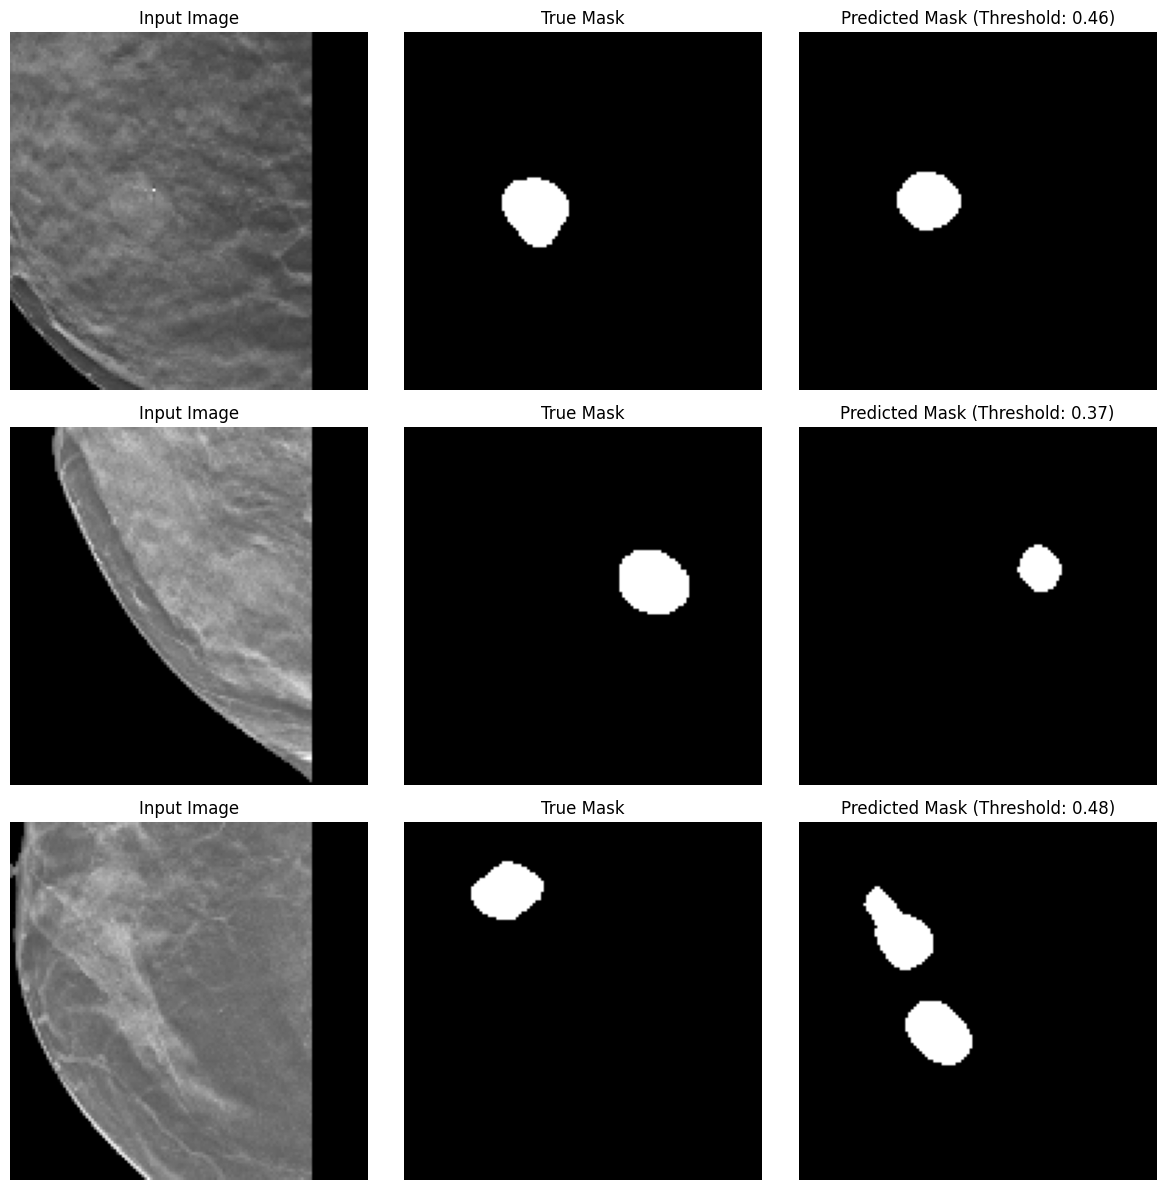

In [ ]:
# Cell 9: Advanced Thresholding and Evaluation
# WRITTEN LARGELY BY CHATGPT

from skimage.filters import threshold_otsu, threshold_minimum
from scipy.ndimage import gaussian_filter, median_filter

# Apply advanced thresholding methods
def apply_thresholding(y_pred_prob, y_true, method="otsu", filter_size=None):
    """Apply thresholding to predictions and calculate metrics."""
    y_pred_binarized = np.zeros_like(y_pred_prob)
    thresholds = []

    for i in range(y_pred_prob.shape[0]):
        prediction = y_pred_prob[i]  # Avoid squeezing to maintain shape

        if method == "gaussian":
            prediction_filtered = gaussian_filter(
                prediction.squeeze(), sigma=filter_size or 15)
            prediction_filtered = prediction_filtered[:, :, np.newaxis]
        elif method == "median":
            prediction_filtered = median_filter(
                prediction.squeeze(), size=filter_size or 15)
            prediction_filtered = prediction_filtered[:, :, np.newaxis]
        else:
            prediction_filtered = prediction

        if method in ["otsu", "gaussian", "median"]:
            threshold = threshold_otsu(prediction_filtered.squeeze())
        elif method == "minimum":
            threshold = threshold_minimum(prediction_filtered.squeeze())
        else:
            threshold = 0.5  # Default threshold

        binarized_prediction = (prediction_filtered > threshold).astype(np.float32)
        y_pred_binarized[i] = binarized_prediction
        thresholds.append(threshold)

    # Flatten arrays for metric calculation
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred_binarized.flatten()

    # Calculate Dice coefficient and IoU
    dice_score = (2.0 * np.sum(y_true_flat * y_pred_flat) + 1e-6) / (
        np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-6)
    iou_score = jaccard_score(y_true_flat, y_pred_flat, average='binary')

    mean_threshold = np.mean(thresholds)
    print(f"Mean Threshold: {mean_threshold:.4f}")
    print(f"Dice Coefficient: {dice_score:.4f}")
    print(f"IoU Score: {iou_score:.4f}")

    return y_pred_binarized, thresholds

# Predict on test data
y_pred_prob = model.predict(X_test)

# Apply thresholding
y_pred_binarized, thresholds = apply_thresholding(
    y_pred_prob, y_test, method="median", filter_size=15)

# Visualization
def plot_sample_predictions(X, y_true, y_pred_binarized, thresholds):
    plt.figure(figsize=(12, 3 * 4))
    for i, idx in enumerate(np.random.randint(0, X.shape[0], 3)):
        # Select images, masks, and predictions
        input_image = X[idx].squeeze()
        true_mask = y_true[idx].squeeze()
        predicted_mask = y_pred_binarized[idx].squeeze()
        threshold = thresholds[idx]

        # Plot input image
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(input_image, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        # Plot true mask
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Plot predicted mask
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title(f'Predicted Mask (Threshold: {threshold:.2f})')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_predictions(X_test, y_test, y_pred_binarized, thresholds)


In [32]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(train_images))
print(np.shape(train_mask_files))

(50, 128, 128, 1)
(10, 128, 128, 1)
(50,)
(50,)
